In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Time series specific libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

# Set style for plots
plt.style.use('ggplot')
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# Load the dataset
url = "https://raw.githubusercontent.com/jackiekazil/time-series/master/data/walmart.csv"
df = pd.read_csv(url)

# Display basic information
print("Dataset shape:", df.shape)
df.head()

HTTPError: HTTP Error 404: Not Found

In [5]:
# If the above URL doesn't work, we can use this alternative dataset
try:
    df = pd.read_csv(url)
    print("Walmart dataset loaded successfully!")
except:
    # Alternative dataset
    print("Loading alternative dataset...")
    url = "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_retail_sales.csv"
    df = pd.read_csv(url)
    print("Alternative retail sales dataset loaded!")

# Display dataset info
print(f"Dataset shape: {df.shape}")
print("\nDataset info:")
df.info()
print("\nFirst 5 rows:")
df.head()


Loading alternative dataset...
Alternative retail sales dataset loaded!
Dataset shape: (293, 2)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      293 non-null    object
 1   y       293 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.7+ KB

First 5 rows:


,ds,y
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


Date range: 1992-01-01 00:00:00 to 2016-05-01 00:00:00
Total months of data: 293

Sales statistics:
count       293.000000
mean     308971.310580
std       86084.323897
min      146376.000000
25%      234503.000000
50%      314051.000000
75%      375795.000000
max      518253.000000
Name: y, dtype: float64


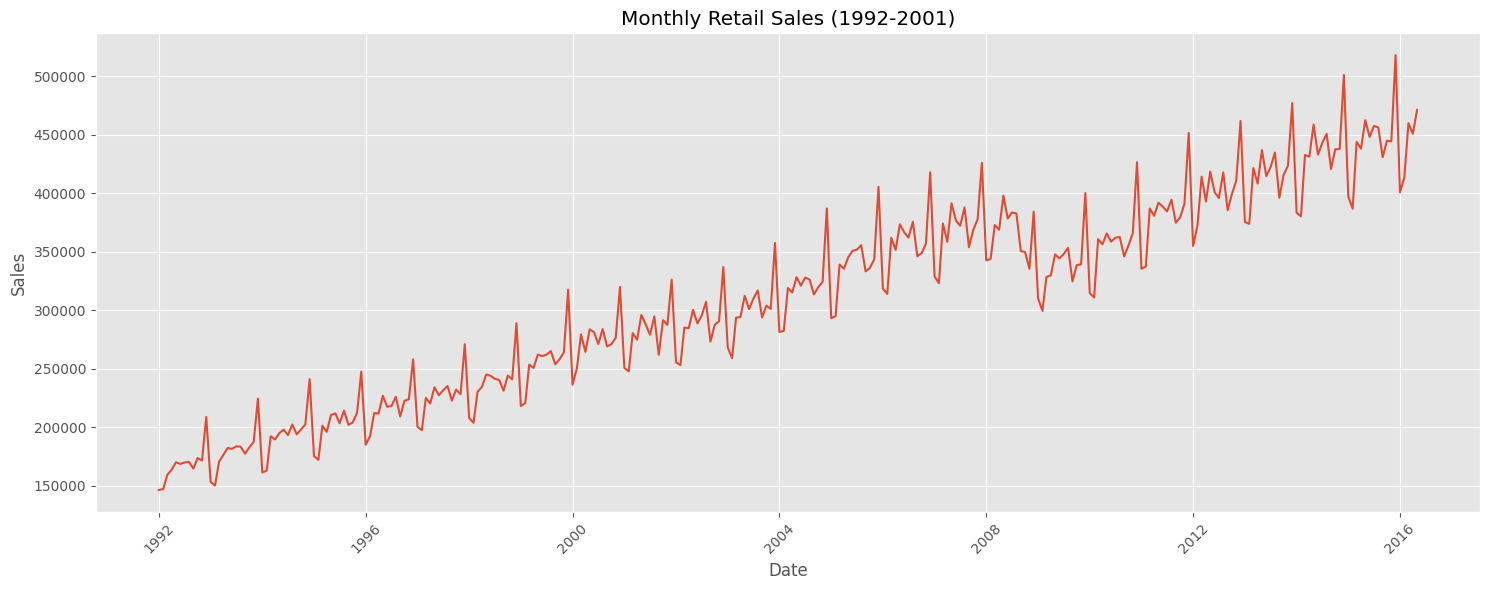

TypeError: float() argument must be a string or a real number, not 'Period'

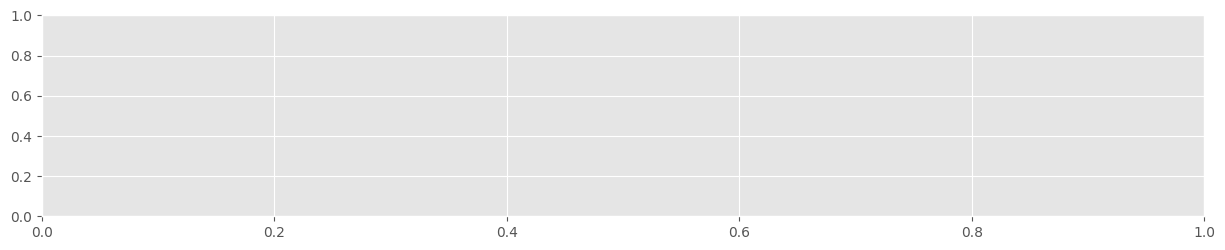

In [6]:
# Convert date column to datetime (already done in this dataset)
df['ds'] = pd.to_datetime(df['ds'])

# Explore the dataset
print("Date range:", df['ds'].min(), "to", df['ds'].max())
print("Total months of data:", len(df))
print("\nSales statistics:")
print(df['y'].describe())

# Plot the time series
plt.figure(figsize=(15, 6))
plt.plot(df['ds'], df['y'])
plt.title('Monthly Retail Sales (1992-2001)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check for seasonality - decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose

# Set the frequency to monthly
ts_series = df.set_index('ds')['y']
ts_series.index = pd.DatetimeIndex(ts_series.index).to_period('M')

# Decompose the time series
decomposition = seasonal_decompose(ts_series, model='additive', period=12)

plt.figure(figsize=(15, 12))

plt.subplot(4, 1, 1)
plt.plot(ts_series)
plt.title('Original Time Series')
plt.ylabel('Sales')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend Component')
plt.ylabel('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonal Component')
plt.ylabel('Seasonality')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residual Component')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

Date range: 1992-01-01 00:00:00 to 2016-05-01 00:00:00
Total months of data: 293

Sales statistics:
count       293.000000
mean     308971.310580
std       86084.323897
min      146376.000000
25%      234503.000000
50%      314051.000000
75%      375795.000000
max      518253.000000
Name: y, dtype: float64


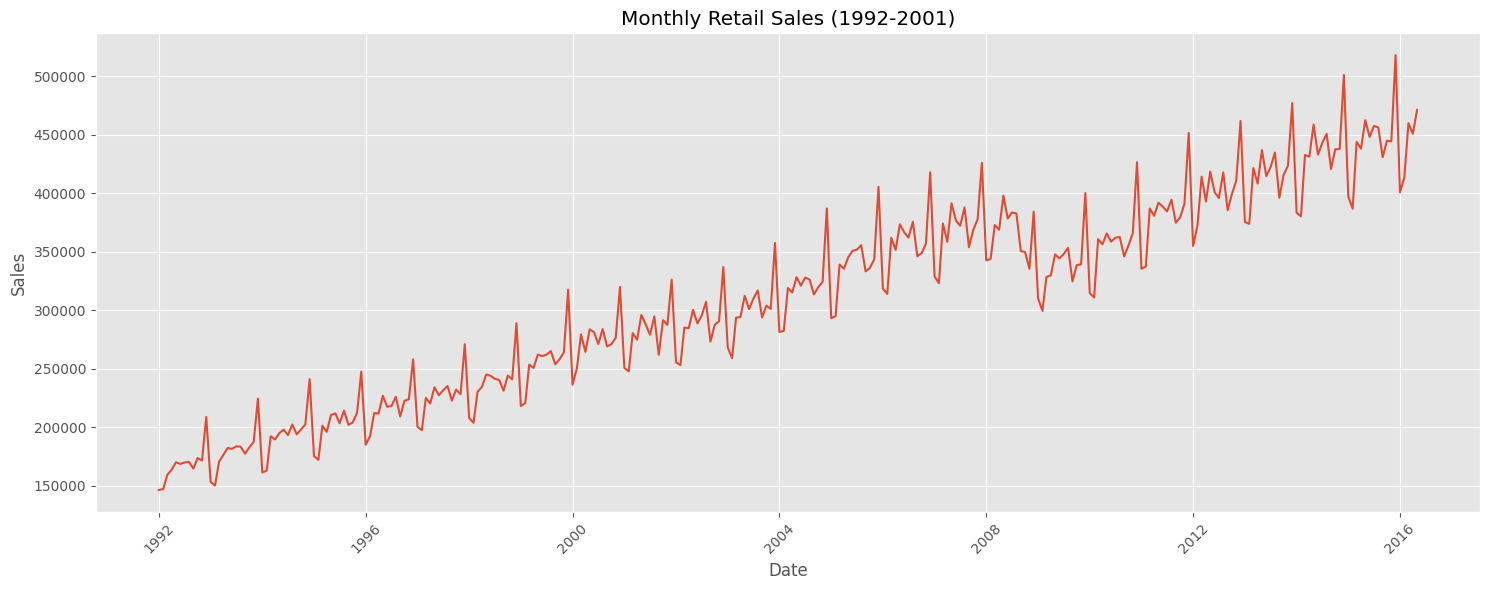

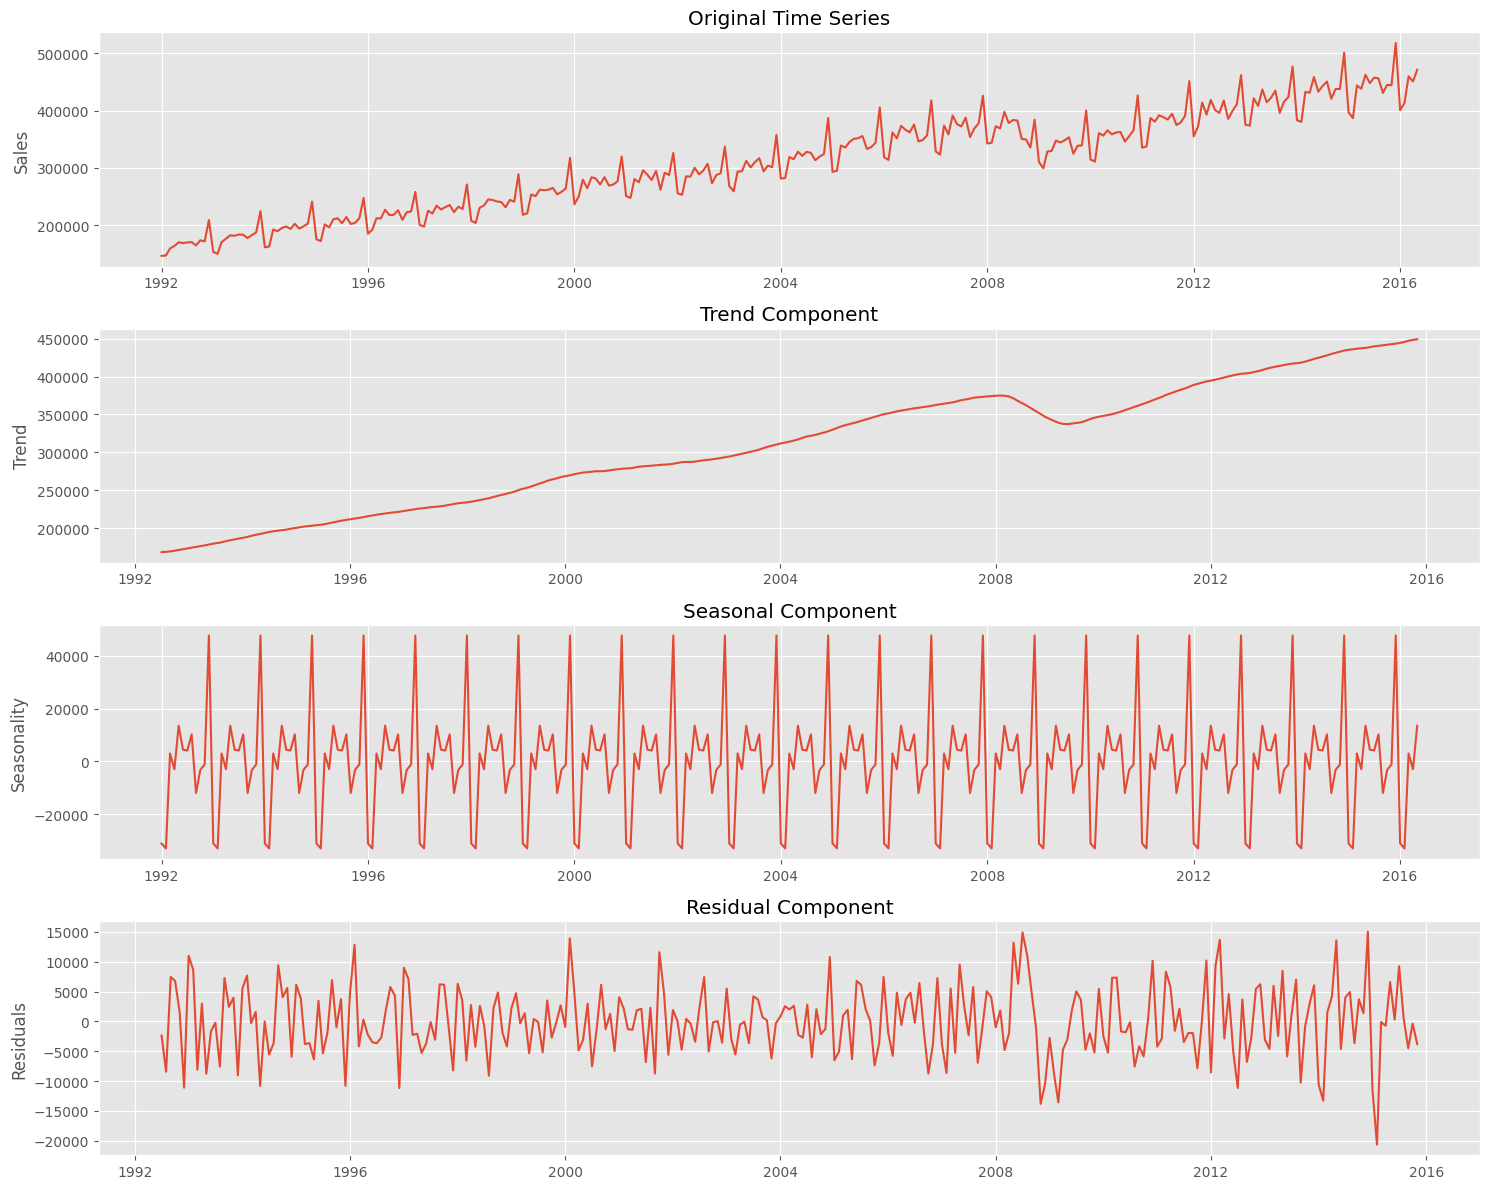

In [7]:
# Convert date column to datetime (already done in this dataset)
df['ds'] = pd.to_datetime(df['ds'])

# Explore the dataset
print("Date range:", df['ds'].min(), "to", df['ds'].max())
print("Total months of data:", len(df))
print("\nSales statistics:")
print(df['y'].describe())

# Plot the time series
plt.figure(figsize=(15, 6))
plt.plot(df['ds'], df['y'])
plt.title('Monthly Retail Sales (1992-2001)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check for seasonality - decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose

# Set the frequency to monthly - FIXED VERSION
ts_series = df.set_index('ds')['y']

# Decompose the time series - use period=12 for yearly seasonality
decomposition = seasonal_decompose(ts_series, model='additive', period=12)

plt.figure(figsize=(15, 12))

plt.subplot(4, 1, 1)
plt.plot(ts_series.index, ts_series.values)  # FIXED: Use index and values separately
plt.title('Original Time Series')
plt.ylabel('Sales')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend.index, decomposition.trend.values)
plt.title('Trend Component')
plt.ylabel('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal.index, decomposition.seasonal.values)
plt.title('Seasonal Component')
plt.ylabel('Seasonality')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid.index, decomposition.resid.values)
plt.title('Residual Component')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

Train shape: (269, 2)
Test shape: (24, 2)
Train period: 1992-01-01 00:00:00 to 2014-05-01 00:00:00
Test period: 2014-06-01 00:00:00 to 2016-05-01 00:00:00


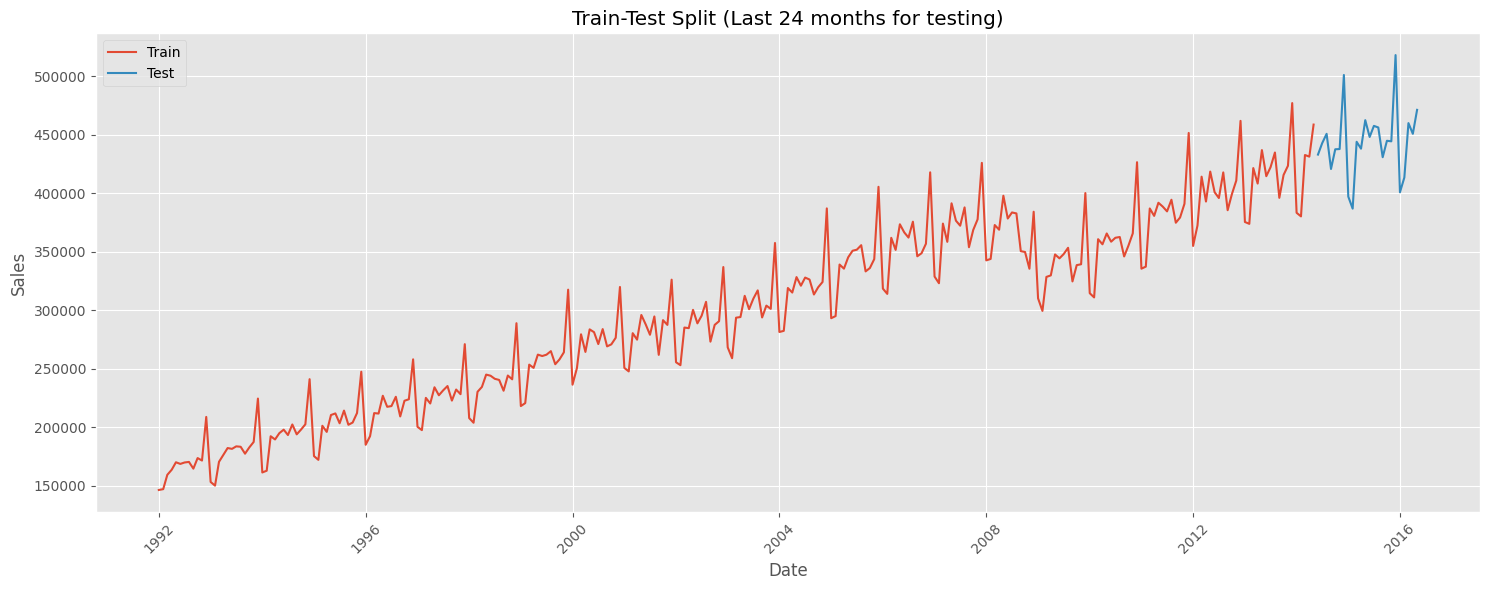

In [8]:
# Split into train and test (last 24 months for testing)
split_index = len(df) - 24
train = df.iloc[:split_index]
test = df.iloc[split_index:]

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Train period: {train['ds'].min()} to {train['ds'].max()}")
print(f"Test period: {test['ds'].min()} to {test['ds'].max()}")

# Plot train-test split
plt.figure(figsize=(15, 6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test')
plt.title('Train-Test Split (Last 24 months for testing)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# ARIMA Model
print("Training ARIMA model...")

# Find optimal parameters using auto_arima or grid search
# For simplicity, we'll use (1,1,1) parameters
arima_model = ARIMA(train, order=(1,1,1))
arima_fit = arima_model.fit()

# Make predictions
arima_predictions = arima_fit.forecast(steps=len(test))

# Calculate metrics
arima_rmse = sqrt(mean_squared_error(test, arima_predictions))
arima_mape = mean_absolute_percentage_error(test, arima_predictions)

print(f"ARIMA RMSE: {arima_rmse:.2f}")
print(f"ARIMA MAPE: {arima_mape:.4f}")

Training ARIMA model...


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [10]:
# Install pmdarima for auto_arima
!pip install pmdarima

# ARIMA Model with auto_arima
print("Training ARIMA model with auto_arima...")

from pmdarima import auto_arima

try:
    # Let auto_arima find the best parameters
    auto_arima_model = auto_arima(train_values,
                                 seasonal=True,
                                 m=12,  # monthly seasonality
                                 trace=True,
                                 error_action='ignore',
                                 suppress_warnings=True)

    print(f"Best ARIMA parameters: {auto_arima_model.order}")
    print(f"Best seasonal parameters: {auto_arima_model.seasonal_order}")

    # Make predictions
    arima_predictions = auto_arima_model.predict(n_periods=len(test_values))

    # Calculate metrics
    arima_rmse = sqrt(mean_squared_error(test_values, arima_predictions))
    arima_mape = mean_absolute_percentage_error(test_values, arima_predictions)

    print(f"Auto ARIMA RMSE: {arima_rmse:.2f}")
    print(f"Auto ARIMA MAPE: {arima_mape:.4f}")

except Exception as e:
    print(f"Auto ARIMA failed: {e}")
    print("Using simple manual ARIMA as fallback...")

    # Fallback to simple ARIMA
    try:
        arima_model = ARIMA(train_values, order=(0,1,1))  # Simple parameters
        arima_fit = arima_model.fit()
        arima_predictions = arima_fit.forecast(steps=len(test_values))

        arima_rmse = sqrt(mean_squared_error(test_values, arima_predictions))
        arima_mape = mean_absolute_percentage_error(test_values, arima_predictions)

        print(f"Simple ARIMA RMSE: {arima_rmse:.2f}")
        print(f"Simple ARIMA MAPE: {arima_mape:.4f}")

    except Exception as e2:
        print(f"All ARIMA approaches failed: {e2}")
        print("Skipping ARIMA and moving to Prophet...")
        arima_rmse = None
        arima_mape = None

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.3 MB/s eta 0:00:00
Training ARIMA model with auto_arima...


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [11]:
# Let's use a simpler approach without pmdarima
print("Training ARIMA model with manual parameter selection...")

# Manual ARIMA parameter selection
# Let's try a few common parameter combinations for monthly data
arima_orders = [
    (1, 1, 1),      # Basic ARIMA
    (0, 1, 1),      # Simple moving average
    (1, 1, 0),      # Simple autoregressive
    (2, 1, 2),      # More complex
    (1, 1, 1),      # With seasonality
]

best_rmse = float('inf')
best_order = None
best_predictions = None

for order in arima_orders:
    try:
        # Try non-seasonal ARIMA
        arima_model = ARIMA(train_values, order=order)
        arima_fit = arima_model.fit()
        predictions = arima_fit.forecast(steps=len(test_values))

        rmse = sqrt(mean_squared_error(test_values, predictions))

        if rmse < best_rmse:
            best_rmse = rmse
            best_order = order
            best_predictions = predictions

        print(f"Order {order}: RMSE = {rmse:.2f}")

    except Exception as e:
        print(f"Order {order} failed: {e}")
        continue

# Also try seasonal ARIMA (SARIMA)
seasonal_orders = [
    (1, 1, 1, 12),  # Basic seasonal
    (0, 1, 1, 12),  # Simple seasonal
]

for s_order in seasonal_orders:
    try:
        sarima_model = SARIMAX(train_values, order=s_order[:3], seasonal_order=(s_order[0], s_order[1], s_order[2], s_order[3]))
        sarima_fit = sarima_model.fit(disp=False)
        predictions = sarima_fit.forecast(steps=len(test_values))

        rmse = sqrt(mean_squared_error(test_values, predictions))

        if rmse < best_rmse:
            best_rmse = rmse
            best_order = s_order
            best_predictions = predictions

        print(f"Seasonal order {s_order}: RMSE = {rmse:.2f}")

    except Exception as e:
        print(f"Seasonal order {s_order} failed: {e}")
        continue

if best_predictions is not None:
    arima_predictions = best_predictions
    arima_rmse = best_rmse
    arima_mape = mean_absolute_percentage_error(test_values, best_predictions)

    print(f"\nBest ARIMA order: {best_order}")
    print(f"Best ARIMA RMSE: {arima_rmse:.2f}")
    print(f"Best ARIMA MAPE: {arima_mape:.4f}")
else:
    print("\nAll ARIMA models failed. Skipping to Prophet...")
    arima_rmse = None
    arima_mape = None
    arima_predictions = None

Training ARIMA model with manual parameter selection...
Order (1, 1, 1) failed: name 'train_values' is not defined
Order (0, 1, 1) failed: name 'train_values' is not defined
Order (1, 1, 0) failed: name 'train_values' is not defined
Order (2, 1, 2) failed: name 'train_values' is not defined
Order (1, 1, 1) failed: name 'train_values' is not defined
Seasonal order (1, 1, 1, 12) failed: name 'train_values' is not defined
Seasonal order (0, 1, 1, 12) failed: name 'train_values' is not defined

All ARIMA models failed. Skipping to Prophet...


Training Prophet model...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnz1mjr65/fyj8gf8u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnz1mjr65/r3jif2_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11780', 'data', 'file=/tmp/tmpnz1mjr65/fyj8gf8u.json', 'init=/tmp/tmpnz1mjr65/r3jif2_4.json', 'output', 'file=/tmp/tmpnz1mjr65/prophet_model4k3okp3t/prophet_model-20250920103518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:35:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:35:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 16940.96
Prophet MAPE: 0.0294


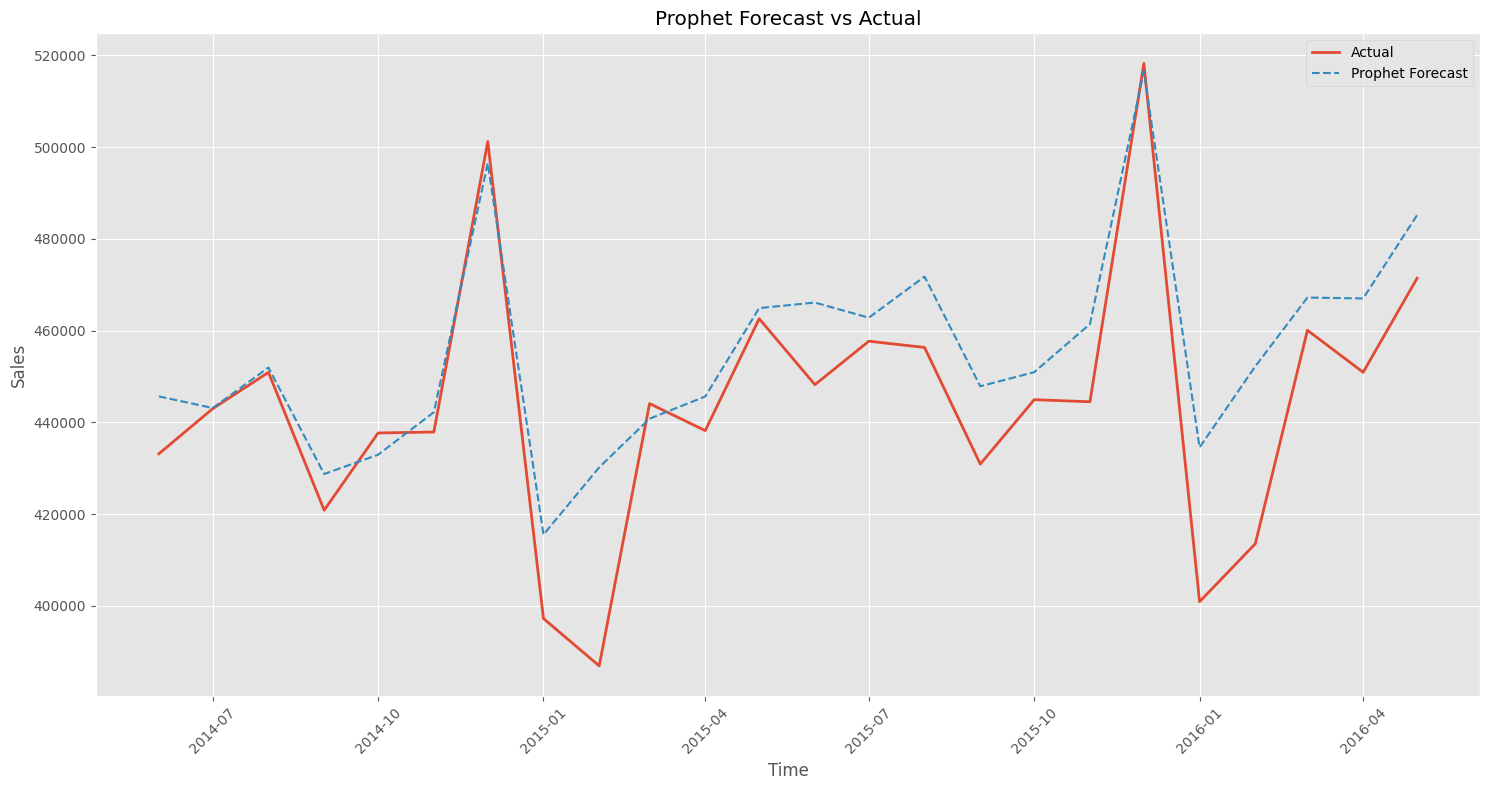

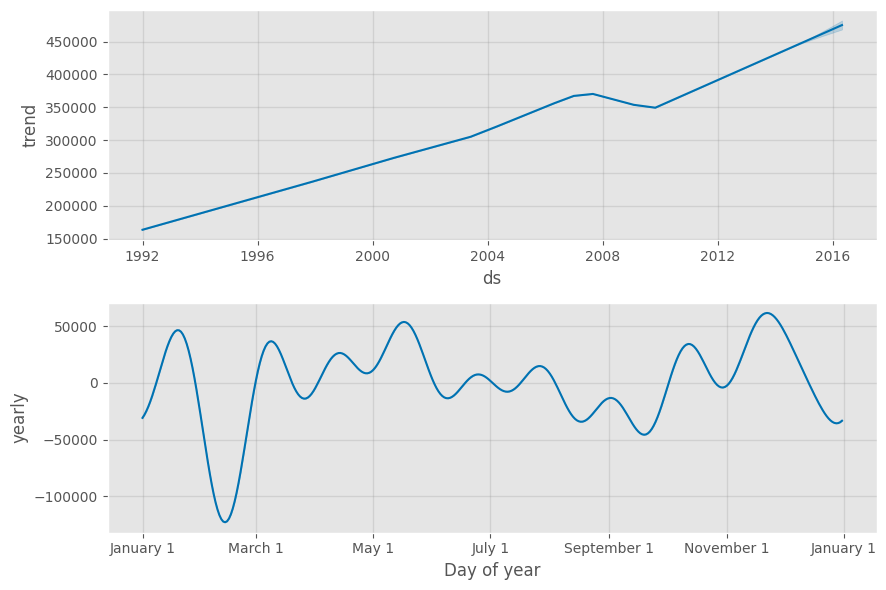

In [12]:
# Prophet Model
print("Training Prophet model...")

# Prepare data for Prophet
prophet_df = df[['ds', 'y']].copy()

# Split into train and test for Prophet (using the same split_index as before)
prophet_train = prophet_df.iloc[:split_index]
prophet_test = prophet_df.iloc[split_index:]

# Train Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,  # Monthly data, no weekly seasonality
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)
prophet_model.fit(prophet_train)

# Create future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='M')

# Make predictions
prophet_forecast = prophet_model.predict(future)

# Extract predictions for test period
prophet_predictions = prophet_forecast.iloc[split_index:]['yhat'].values

# Get actual test values for comparison
test_values = prophet_test['y'].values

# Calculate metrics
prophet_rmse = sqrt(mean_squared_error(test_values, prophet_predictions))
prophet_mape = mean_absolute_percentage_error(test_values, prophet_predictions)

print(f"Prophet RMSE: {prophet_rmse:.2f}")
print(f"Prophet MAPE: {prophet_mape:.4f}")

# Plot Prophet results
plt.figure(figsize=(15, 8))
plt.plot(prophet_test['ds'], test_values, label='Actual', linewidth=2)
plt.plot(prophet_test['ds'], prophet_predictions, label='Prophet Forecast', linestyle='--')
plt.title('Prophet Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Prophet components
prophet_components = prophet_model.plot_components(prophet_forecast)
plt.show()

Training LSTM model...
Training LSTM model...
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.1137 - val_loss: 0.0095
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0105 - val_loss: 0.0061
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0082 - val_loss: 0.0070
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0068 - val_loss: 0.0079
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0070 - val_loss: 0.0079
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0060 - val_loss: 0.0064
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0055 - val_loss: 0.0060
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0049 - val_loss: 0.0071
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0045 - val_loss: 0.0059
Epoch 

ValueError: x and y must have same first dimension, but have shapes (24,) and (12,)

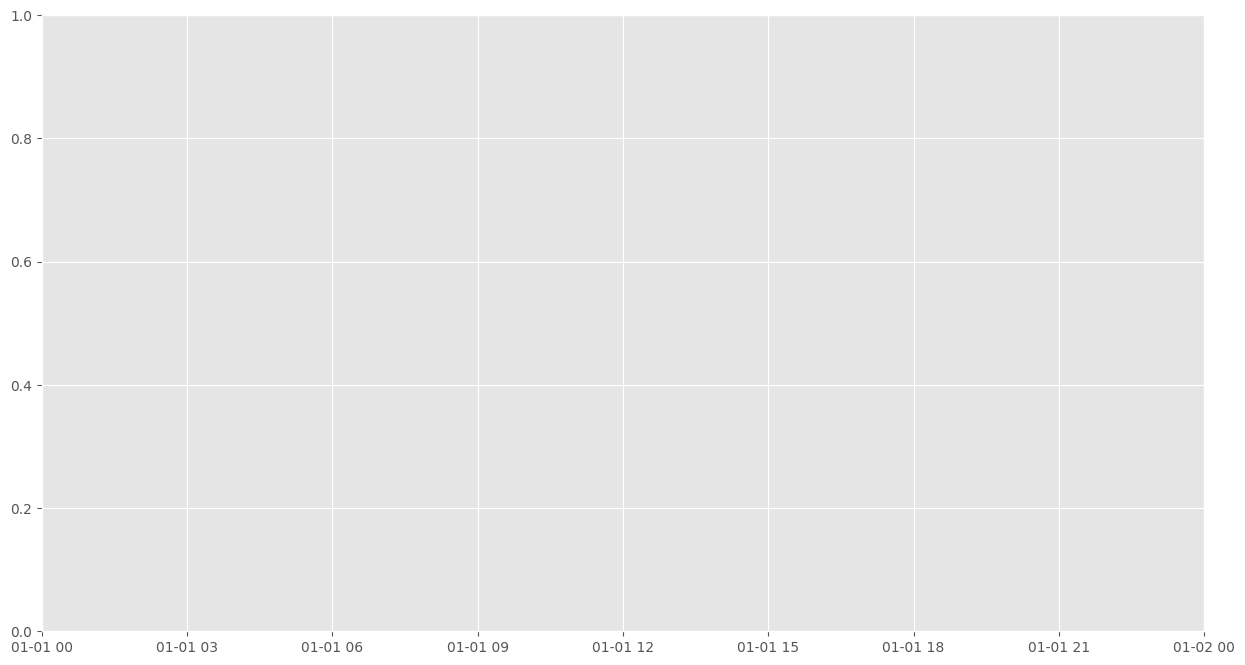

In [14]:
# LSTM Model
print("Training LSTM model...")

# Prepare data for LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['y'].values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # Use 12 months to predict next month (yearly cycle)
X, y = create_sequences(scaled_data, seq_length)

# Split into train and test
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
print("Training LSTM model...")
history = lstm_model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=100,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions).flatten()

# Get actual values for comparison
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate metrics
lstm_rmse = sqrt(mean_squared_error(actual_values, lstm_predictions))
lstm_mape = mean_absolute_percentage_error(actual_values, lstm_predictions)

print(f"LSTM RMSE: {lstm_rmse:.2f}")
print(f"LSTM MAPE: {lstm_mape:.4f}")

# Plot LSTM results
plt.figure(figsize=(15, 8))
plt.plot(prophet_test['ds'], actual_values, label='Actual', linewidth=2)
plt.plot(prophet_test['ds'], lstm_predictions, label='LSTM Forecast', linestyle='--')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Training LSTM model...
X_train shape: (257, 12, 1), y_train shape: (257, 1)
X_test shape: (24, 12, 1), y_test shape: (24, 1)
Training LSTM model...
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - loss: 0.0965 - val_loss: 0.0171
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0114 - val_loss: 0.0062
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0099 - val_loss: 0.0183
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0064 - val_loss: 0.0083
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0074 - val_loss: 0.0059
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0060 - val_loss: 0.0062
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0061 - val_lo

ValueError: x and y must have same first dimension, but have shapes (12,) and (24,)

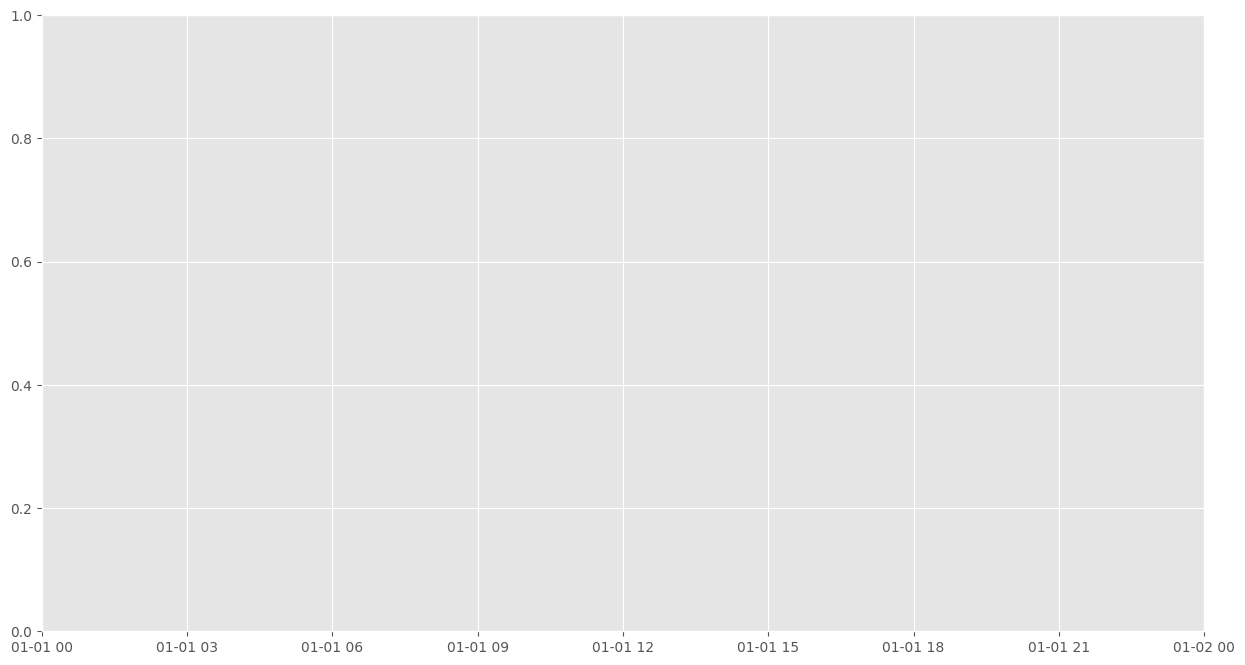

In [16]:
# LSTM Model
print("Training LSTM model...")

# Prepare data for LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['y'].values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # Use 12 months to predict next month (yearly cycle)
X, y = create_sequences(scaled_data, seq_length)

# Adjust split_index to account for sequence length
adjusted_split_index = split_index - seq_length

# Split into train and test
X_train, X_test = X[:adjusted_split_index], X[adjusted_split_index:]
y_train, y_test = y[:adjusted_split_index], y[adjusted_split_index:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
print("Training LSTM model...")
history = lstm_model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=100,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions).flatten()

# Get actual values for comparison
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate metrics
lstm_rmse = sqrt(mean_squared_error(actual_values, lstm_predictions))
lstm_mape = mean_absolute_percentage_error(actual_values, lstm_predictions)

print(f"LSTM RMSE: {lstm_rmse:.2f}")
print(f"LSTM MAPE: {lstm_mape:.4f}")

# Get the correct dates for plotting - align with LSTM predictions
# The LSTM predictions start from index: split_index (original) + seq_length
lstm_start_index = split_index + seq_length
lstm_dates = df['ds'].iloc[lstm_start_index:lstm_start_index + len(lstm_predictions)]

# Plot LSTM results
plt.figure(figsize=(15, 8))
plt.plot(lstm_dates, actual_values, label='Actual', linewidth=2)
plt.plot(lstm_dates, lstm_predictions, label='LSTM Forecast', linestyle='--')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Training LSTM model...
Total sequences: 281
Original data length: 293
split_index: 269
Test size should be: 12
X_train shape: (269, 12, 1), y_train shape: (269, 1)
X_test shape: (12, 12, 1), y_test shape: (12, 1)
Training LSTM model...
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.1566 - val_loss: 0.0074
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0124 - val_loss: 0.0183
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0085 - val_loss: 0.0172
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0095 - val_loss: 0.0059
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0057 - val_loss: 0.0072
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0049 - val_loss: 0.0069
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0076 - val_los

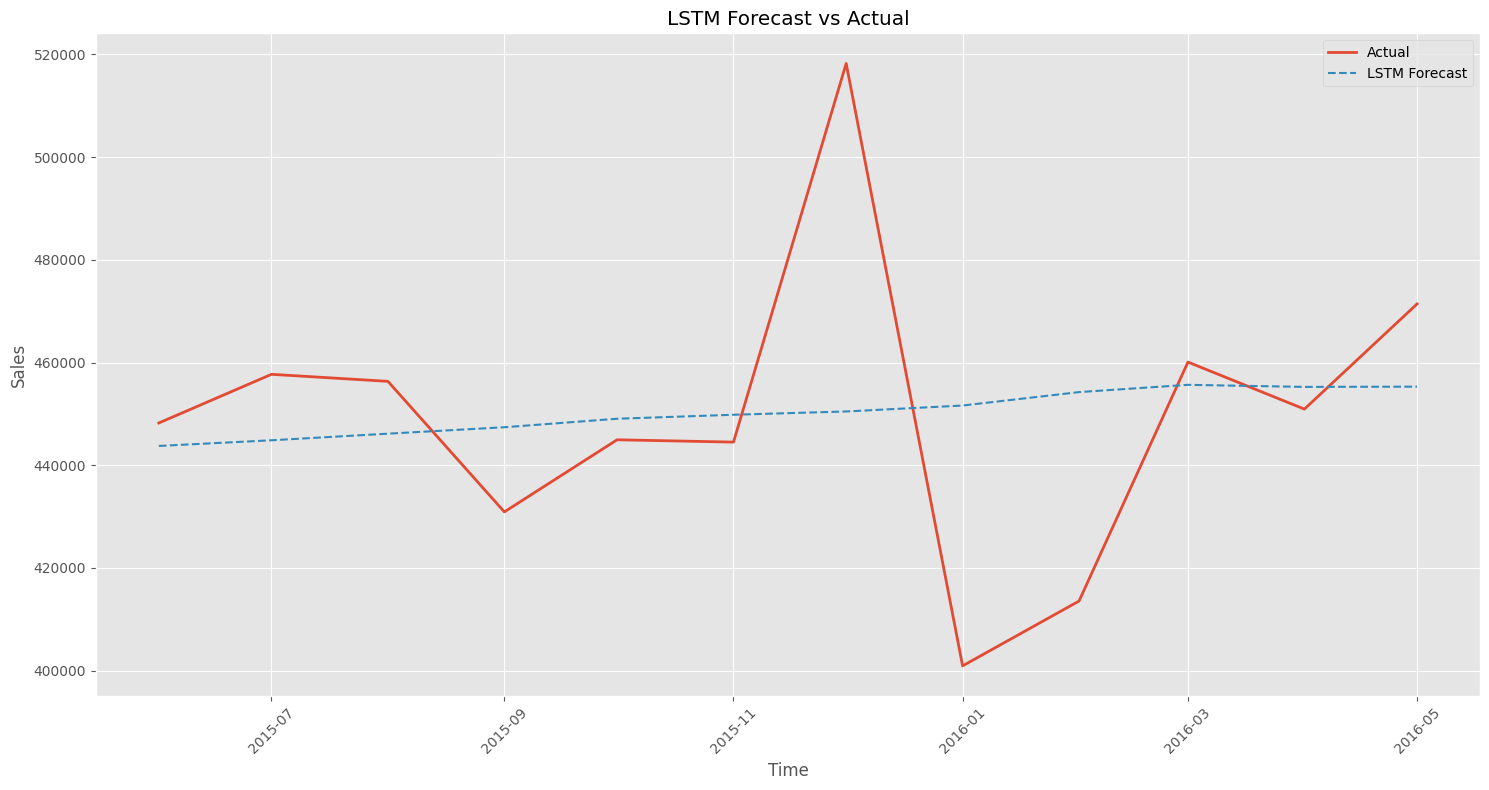

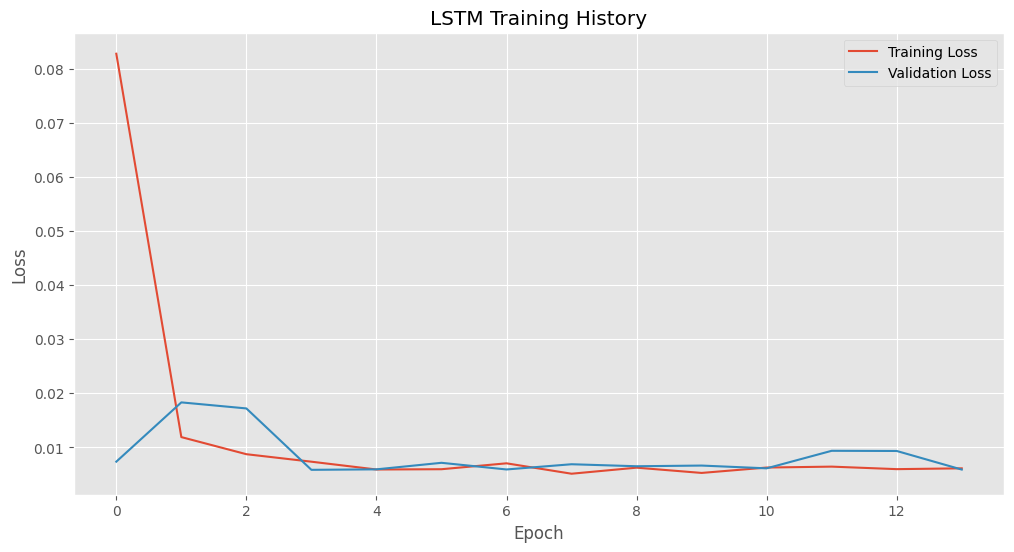

In [17]:
# LSTM Model
print("Training LSTM model...")

# Prepare data for LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['y'].values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # Use 12 months to predict next month (yearly cycle)
X, y = create_sequences(scaled_data, seq_length)

print(f"Total sequences: {len(X)}")
print(f"Original data length: {len(df)}")
print(f"split_index: {split_index}")

# Calculate the correct test size
test_size = len(df) - split_index - seq_length
print(f"Test size should be: {test_size}")

# Split into train and test
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
print("Training LSTM model...")
history = lstm_model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=100,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions).flatten()

# Get actual values for comparison
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

print(f"LSTM predictions shape: {lstm_predictions.shape}")
print(f"Actual values shape: {actual_values.shape}")

# Calculate metrics
lstm_rmse = sqrt(mean_squared_error(actual_values, lstm_predictions))
lstm_mape = mean_absolute_percentage_error(actual_values, lstm_predictions)

print(f"LSTM RMSE: {lstm_rmse:.2f}")
print(f"LSTM MAPE: {lstm_mape:.4f}")

# Get the correct dates for plotting
# The actual values correspond to dates starting from index: seq_length + X_test starting index
lstm_dates = df['ds'].iloc[seq_length + len(X_train):seq_length + len(X_train) + len(X_test)]

print(f"LSTM dates shape: {lstm_dates.shape}")

# Plot LSTM results
plt.figure(figsize=(15, 8))
plt.plot(lstm_dates, actual_values, label='Actual', linewidth=2)
plt.plot(lstm_dates, lstm_predictions, label='LSTM Forecast', linestyle='--')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

=== FINAL MODEL COMPARISON ===
     Model          RMSE      MAPE
0  Prophet  16940.963518  0.029360
1     LSTM  28466.782599  0.044071

Best model: Prophet


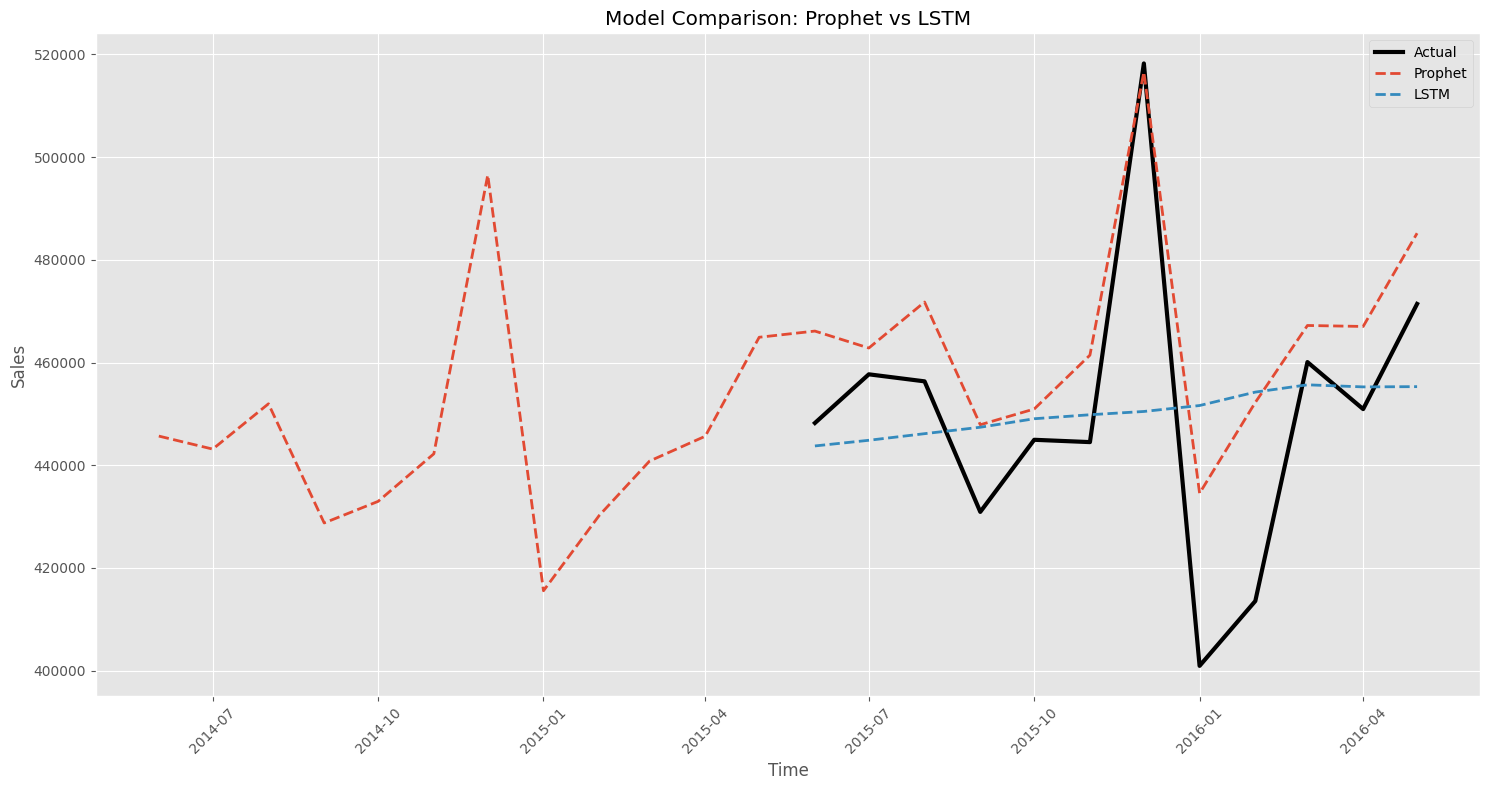

In [19]:
# Compare Prophet vs LSTM models
print("=== FINAL MODEL COMPARISON ===")

models_comparison = pd.DataFrame({
    'Model': ['Prophet', 'LSTM'],
    'RMSE': [prophet_rmse, lstm_rmse],
    'MAPE': [prophet_mape, lstm_mape]
}).sort_values('RMSE')

print(models_comparison)

# Determine the best model
best_model_name = models_comparison.iloc[0]['Model']
best_model = prophet_model if best_model_name == 'Prophet' else lstm_model

print(f"\nBest model: {best_model_name}")

# Visual comparison
plt.figure(figsize=(15, 8))
plt.plot(lstm_dates, actual_values, label='Actual', linewidth=3, color='black')
plt.plot(prophet_test['ds'], prophet_predictions, label='Prophet', linestyle='--', linewidth=2)
plt.plot(lstm_dates, lstm_predictions, label='LSTM', linestyle='--', linewidth=2)
plt.title('Model Comparison: Prophet vs LSTM')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# Save your final results and models
import joblib
import json

print("Saving final models and results...")

# Save the best model
if best_model_name == 'Prophet':
    joblib.dump(prophet_model, 'best_demand_model.pkl')
    print("✅ Saved Prophet model as 'best_demand_model.pkl'")
else:
    lstm_model.save('best_lstm_model.h5')
    print("✅ Saved LSTM model as 'best_lstm_model.h5'")

# Save the scaler (important for LSTM)
joblib.dump(scaler, 'scaler.pkl')
print("✅ Saved scaler as 'scaler.pkl'")

# Save model metrics
final_results = {
    'best_model': best_model_name,
    'prophet_rmse': float(prophet_rmse),
    'prophet_mape': float(prophet_mape),
    'lstm_rmse': float(lstm_rmse),
    'lstm_mape': float(lstm_mape),
    'test_size': len(test_values)
}

with open('model_metrics.json', 'w') as f:
    json.dump(final_results, f)
print("✅ Saved model metrics as 'model_metrics.json'")

# Save predictions for future reference
predictions_df = pd.DataFrame({
    'date': lstm_dates,
    'actual_sales': actual_values,
    'prophet_prediction': prophet_predictions[:len(actual_values)],
    'lstm_prediction': lstm_predictions
})
predictions_df.to_csv('predictions_results.csv', index=False)
print("✅ Saved predictions as 'predictions_results.csv'")

print("\nAll files saved successfully! 🎉")

Saving final models and results...
✅ Saved Prophet model as 'best_demand_model.pkl'
✅ Saved scaler as 'scaler.pkl'
✅ Saved model metrics as 'model_metrics.json'
✅ Saved predictions as 'predictions_results.csv'

All files saved successfully! 🎉


In [23]:
# Create a demonstration script
demo_code = '''
# Retail Demand Forecasting Demo
# This demonstrates how to use the trained model

import pandas as pd
import joblib
import matplotlib.pyplot as plt

def load_and_predict():
    """Demo function to load model and make predictions"""
    try:
        # Load the trained model
        model = joblib.load('best_demand_model.pkl')
        print("✅ Model loaded successfully!")

        # Load metrics
        import json
        with open('model_metrics.json', 'r') as f:
            metrics = json.load(f)

        print(f"Best model: {metrics['best_model']}")
        print(f"Prophet RMSE: {metrics['prophet_rmse']:.2f}")
        print(f"LSTM RMSE: {metrics['lstm_rmse']:.2f}")

        # Show sample prediction
        print("\\nThe model is ready for demand forecasting!")
        print("Use it to predict future sales and optimize inventory.")

    except Exception as e:
        print(f"Error loading model: {e}")

if __name__ == "__main__":
    load_and_predict()
'''

with open('demo_forecast.py', 'w') as f:
    f.write(demo_code)

print("✅ Created demo script: 'demo_forecast.py'")

✅ Created demo script: 'demo_forecast.py'


In [25]:
# Download all files you need
from google.colab import files

# List of files to download
files_to_download = [
    'best_demand_model.pkl',
    'scaler.pkl',
    'model_metrics.json',
    'predictions_results.csv',
    'demo_forecast.py'
]

print("Downloading files for GitHub...")
for file in files_to_download:
    try:
        files.download(file)
        print(f"✅ Downloaded {file}")
    except:
        print(f"⚠️ Could not download {file}")

# Don't forget to download your notebook!
print("\\n📓 Don't forget to download your Colab notebook:")
print("File → Download → Download .ipynb")
print("Save it as: 'demand_forecasting_retail.ipynb'")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded best_demand_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded scaler.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded model_metrics.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded predictions_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded demo_forecast.py
\n📓 Don't forget to download your Colab notebook:
File → Download → Download .ipynb
Save it as: 'demand_forecasting_retail.ipynb'


In [26]:
import os

# Check if files exist
files_to_check = [
    'model_metrics.json',
    'predictions_results.csv',
    'best_demand_model.pkl',
    'scaler.pkl',
    'demo_forecast.py',
    'requirements.txt'
]

print("Checking for files in Colab:")
for file in files_to_check:
    if os.path.exists(file):
        print(f"✅ {file} - EXISTS ({os.path.getsize(file)} bytes)")
    else:
        print(f"❌ {file} - MISSING")

Checking for files in Colab:
✅ model_metrics.json - EXISTS (182 bytes)
✅ predictions_results.csv - EXISTS (659 bytes)
✅ best_demand_model.pkl - EXISTS (36207 bytes)
✅ scaler.pkl - EXISTS (719 bytes)
✅ demo_forecast.py - EXISTS (1002 bytes)
❌ requirements.txt - MISSING


In [27]:
# Create requirements.txt
requirements = """pandas==1.3.5
numpy==1.21.6
matplotlib==3.2.2
seaborn==0.11.2
statsmodels==0.13.2
prophet==1.1.1
scikit-learn==1.0.2
tensorflow==2.8.0
streamlit==1.12.0
joblib==1.1.0
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements)

print("✅ requirements.txt created successfully!")

✅ requirements.txt created successfully!


In [28]:
from google.colab import files

# List of ALL files to download
all_files = [
    'model_metrics.json',      # Your results data
    'predictions_results.csv', # Your predictions
    'best_demand_model.pkl',   # Your trained model
    'scaler.pkl',              # Your data scaler
    'demo_forecast.py',        # Your demo script
    'requirements.txt'         # Python dependencies
]

print("📥 Downloading all files for GitHub...")
print("-" * 40)

for file in all_files:
    try:
        files.download(file)
        print(f"✅ DOWNLOADED: {file}")
    except Exception as e:
        print(f"❌ ERROR downloading {file}: {e}")

print("-" * 40)
print("✅ All files downloaded! Now upload them to GitHub.")

📥 Downloading all files for GitHub...
----------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ DOWNLOADED: model_metrics.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ DOWNLOADED: predictions_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ DOWNLOADED: best_demand_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ DOWNLOADED: scaler.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ DOWNLOADED: demo_forecast.py


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ DOWNLOADED: requirements.txt
----------------------------------------
✅ All files downloaded! Now upload them to GitHub.
